In [1]:
from datetime import datetime
import json
import os
import sys

# gensim
import gensim
import gensim.corpora as corpara
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pytz
import pickle

# lda plotting tools
import pyLDAvis
import pyLDAvis.gensim

#sklearn
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer


# nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer

from time import time


In [2]:
HOME = os.environ['HOME']
KEYS = f'{HOME}/config/db.json'
ENV = 'dev'
NOW = datetime.utcnow().replace(tzinfo=pytz.utc)
TODAY = NOW.date()

DATA_DIR = '../data'
MODEL_DIR = '../model'
SQL_DIR = '../sql'
OUT_DIR = '../output'

DEV = True

In [3]:
if DEV:
    RUN_DATE = '2021-01-15'
else:
    RUN_DATE = str(NOW.date())
# RUN_DATE = str(NOW.date())
RUN_DATE

'2021-01-15'

# Partitional Clustering

### 1. Fetch data

In [4]:
with open(f'{OUT_DIR}/commentMapper.json', 'r') as f:
    comment_mapper = json.load(f)

In [5]:
with open(f'{OUT_DIR}/titleMapper.json', 'r') as f:
    title_mapper = json.load(f)

In [6]:
commentsByNGram = pd.read_csv(f'{OUT_DIR}/commentsByNGramFreq.csv')
commentsByNGram.head()

,counts,comment,reduced_500,reduced_200,reduced_150,reduced_100,reduced_50
0,1,undergraduate cybersec train included required...,write,No Match Found,No Match Found,No Match Found,No Match Found
1,1,meant prettier dunno thinking prettify tweak d...,4 4,4,4,4,No Match Found
2,1,recall note december light relax holiday secur...,security,security,security,security,security
3,1,fucking biden,No Match Found,No Match Found,No Match Found,No Match Found,No Match Found
4,1,meaningful add assuming snmp write access enab...,solve problems,access,access,No Match Found,No Match Found


In [7]:
titlesByNGram = pd.read_csv(f'{OUT_DIR}/titlesByNGramFreq.csv')
titlesByNGram.head()

,counts,title,reduced_500,reduced_200,reduced_150,reduced_100,reduced_50
0,2301,timnit gebru google megathread,timnit gebru google megathread,timnit gebru,google,google,No Match Found
1,1075,hundreds google employees unionize culminating...,google,google,google,google,No Match Found
2,755,nvidia longer sending hardware unboxed review ...,hardware unboxed,hardware,hardware,No Match Found,No Match Found
3,674,ltt review macbooks,No Match Found,No Match Found,No Match Found,No Match Found,No Match Found
4,671,NaN,No Match Found,No Match Found,No Match Found,No Match Found,No Match Found


In [8]:
commentsByNGram.shape

(212029, 7)

In [9]:
titlesByNGram.shape

(13202, 7)

In [10]:
titles_w_terms = pd.read_csv(f'{OUT_DIR}/titles_w_terms.csv')
comments_w_terms = pd.read_csv(f'{OUT_DIR}/comments_w_terms.csv')

In [25]:
titles_w_terms

,counts,title,reduced_500,reduced_200,reduced_150,reduced_100,reduced_50,title_terms
0,552,thread product manager google google cloud pla...,google,google,google,google,No Match Found,{'aws'}
1,504,ruby released,No Match Found,No Match Found,No Match Found,No Match Found,No Match Found,{'ruby'}
2,481,git 15 created svn created 5 git cvs 15 svn,5,5,5,5,No Match Found,{'git'}
3,400,nissan source code leaked online git repo misc...,source code,source code,source code,source code,source code,{'git'}
4,381,cookie github blog,github,No Match Found,No Match Found,No Match Found,No Match Found,{'github'}
...,...,...,...,...,...,...,...,...
2809,1,web push notifications ios happen,web,No Match Found,No Match Found,No Match Found,No Match Found,{'ios'}
2810,1,configure sfp ports cat 2960x vlan,No Match Found,No Match Found,No Match Found,No Match Found,No Match Found,{'vlan'}
2811,1,azure file sync s3 storage,file,No Match Found,No Match Found,No Match Found,No Match Found,{'azure'}
2812,1,aws tutorial covers aspects development devops,No Match Found,No Match Found,No Match Found,No Match Found,No Match Found,{'aws'}


In [26]:
comments_w_terms

,counts,comment,reduced_500,reduced_200,reduced_150,reduced_100,reduced_50,comment_terms
0,1,undergraduate cybersec train included required...,write,No Match Found,No Match Found,No Match Found,No Match Found,{'list'}
1,1,meaningful add assuming snmp write access enab...,solve problems,access,access,No Match Found,No Match Found,{'access'}
2,1,l2tp ipsec primally vpn gateway unifi security...,network security,security,security,security,security,{'vpn'}
3,1,interesting virtualbox handles case,case,case,case,case,No Match Found,{'virtualbox'}
4,1,companies building adopting internal developer...,tech companies,tech companies,working,working,No Match Found,{'puppet'}
...,...,...,...,...,...,...,...,...
43776,1,connection vm host network configured vlan pre...,4 4,network,network,network,network,{'vlan'}
43777,1,compare python,No Match Found,No Match Found,No Match Found,No Match Found,No Match Found,{'python'}
43778,1,summarisation excludes 10 7 24 list routes 10 ...,entry level,entry level,entry level,entry level,entry level,{'list'}
43779,1,admittedly havent looked havent bottomed docke...,No Match Found,No Match Found,No Match Found,No Match Found,No Match Found,{'docker'}


In [13]:
data = pd.read_csv(f'{DATA_DIR}/clean_data_{RUN_DATE}.csv')

In [14]:
data

,comment,title
0,reason place build logic plugin,building jenkins pipeline
1,thread cloud prem infra responding context,devops platform eng
2,technologyconversations podcast episodes techn...,podcasts
3,ecosystem evolved greatly jenkins hayday chang...,building jenkins pipeline
4,enjoy learning techs teaching developer advoca...,industries life devops
...,...,...
212024,free simple,executives pay salary reach 24 7
212025,control electronics,vw audi cut german output semiconductor shortage
212026,easier terminate boss bad connection 72 bad,patch panel cost disparity
212027,moving parts seize cold long term storage tape...,nand companies making slc mlc


In [15]:
cmnt_title_ngrams = pd.read_csv(f'{DATA_DIR}/cmnt_title_ngrams.csv')

In [16]:
cmnt_title_ngrams.head()

,ngram,counts,multiplier,n
0,wikipedia org wiki,637,599.508675,3
1,open source,795,557.274270,2
2,org wiki,656,459.838894,2
3,wikipedia org,638,447.221364,2
4,ray tracing,584,409.368772,2


### 2. Preparing data for vectorization

In [17]:
gist_file = open(f'{DATA_DIR}/gist_stopwords.txt', 'r')
try:
    content = gist_file.read()
    stopwords = content.split(",")
finally:
    gist_file.close()

In [18]:
stop_words = list(set(text.ENGLISH_STOP_WORDS.union([
    'abov', 'afterward', 'alon', 'alreadi', 'alway', 
    'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam',
    'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 
    'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 
    'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 
    'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 
    'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 
    'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 
    'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 
    'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc',
    'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv',
    'anywh', 'el', 'elsewh', 'everywh', 'ind', 'otherwi', 'plea', 'somewh',
    'lol', 'nice', 'yeah', 'cool', 'dont', 'ill', 'wow', 'people', 
    'time',  'good', '0','1', '2', '3', 'isnt', 'things', 'thing', 
    'lot', 'doesnt', 'ive', 'work', 'hahahahaha', 'hahahaha', 'years', 
    '', 'true', '_', '_ _', '_ _ _', 'awesome', 'shit', 'guy', 'itll',
    'they\'ll',' theyve', 'https', 'pretty', 'didnt', 'abl', 'accord', 
    'actual', 'affect', 'announc', 'anybodi', 'anymor', 'appar', 
    'appreci', 'appropri', 'approxim', 'aris', 'articl', 'asid',
    'associ', 'avail', 'awesom', 'believ', 'briefli', 'caus', 'chang', 
    'clear', 'concern', 'consequ', 'consid', 'correspond', 'cours', 
    'current', 'definit', 'despit', 'differ', 'doe', 'downward', 
    'eighti', 'entir', 'especi', 'everybodi', 'exact', 'exampl', 
    'fifi', 'follow', 'furthermor', 'goe', 'greet', 'happen', 
    'hard', 'hope', "i'v", 'ignor', 'immedi', 'import', 'indic', 
    'inform', 'invent', 'larg', 'late', 'littl', 'main', 'mayb', 
    'meantim', 'mere', 'necessari', 'necessarili', 'nineti', 'normal', 
    'note', 'obvious', 'omit', 'outsid', 'overal', 'owe', 'peopl', 
    'place', 'poor', 'possibl', 'potenti', 'predomin', 'presum', 
    'pretti', 'previous', 'primarili', 'probabl', 'prompt', 'provid', 
    'quick', 'quit', 'readili', 'realli', 'reason', 'regard', 'relat', 
    'respect', 'result', 'selv', 'sensibl', "should'v", 'signific',
    'slight', 'somebodi', 'sorri', 'specif', 'specifi', 'strong',
    'substanti', 'success', 'suffici', 'tend', "that'v", "there'l",
    "there'v", 'therer', "they'r", "they'v", 'theyr', 'theyv', 'tri', 
    'truli', 'unfortun', 'unlik', 'usual', 'valu', 'volumtyp', "we'r",
    "we'v", 'welcom', 'whomev', 'wide', 'word', 'year', "you'r", "you'v",
    'ari', 'cour', 'signif', 'youll', 'youv', 'point', 'stuff']
    ).union(stopwords)))

In [19]:
len(stop_words)

1414

#### TF-IDF

In [20]:
vectorizer = TfidfVectorizer(stop_words=stop_words)

In [21]:
X = vectorizer.fit_transform(data.comment)

/Users/rsawhney/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['mon', 'theyve'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [22]:
word_features = vectorizer.get_feature_names()
print(len(word_features))
print(word_features[30000:30100])

120015
['catshit', 'catskills', 'cattiness', 'catting', 'cattle', 'cattools', 'catty', 'catv', 'catx', 'caubuchon', 'caucasian', 'caucasoid', 'cauchy', 'caucus', 'caueses', 'caugh', 'caught', 'caugth', 'causaimpact', 'causal', 'causal_product', 'causalimpact', 'causalities', 'causality', 'causally', 'causalml', 'causation', 'causative', 'caused', 'causeistoleyouroauth', 'causes_of_soft_errors', 'causesd', 'causing', 'caustic', 'caustics', 'cauterization', 'caution', 'cautionary', 'cautioning', 'cautions', 'cautious', 'cautiously', 'cavaets', 'cavalier', 'cavalierly', 'cave', 'caveat', 'caveats', 'caved', 'caveman', 'cavemen', 'caveofprogramming', 'caves', 'caviar', 'caviats', 'caving', 'cavity', 'cavium', 'caviums', 'cawcaw', 'cayenne', 'cayennes', 'cayman', 'caymans', 'caz', 'cazmob', 'cazzo', 'cb', 'cb15', 'cb20', 'cb2077', 'cb23', 'cb280hk', 'cb59tzf', 'cb77', 'cb_integration', 'cb_offset_t', 'cba', 'cba850', 'cba850s', 'cbackup', 'cbam', 'cbb', 'cbc', 'cbd', 'cbd4b502', 'cbdcs', 'c

#### Stemming and tokenizing

In [27]:
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]

In [28]:
vectorizer2 = TfidfVectorizer(stop_words=stop_words, tokenizer=tokenize)
X2 = vectorizer2.fit_transform(data.comment)
word_features2 = vectorizer2.get_feature_names()

In [29]:
print(len(word_features2))
print(word_features2[:50]) 

68316
['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'aaaaaaaaaahhhhh', 'aaaaaaaaaak', 'aaaaaaaaaec', 'aaaaaaaaah', 'aaaaaaaaau', 'aaaaaaaabo', 'aaaaaaaaejo', 'aaaaaaaaekq', 'aaaaaaah', 'aaaaaah', 'aaaaaall', 'aaaaaand', 'aaaaaarrrrrrrggggggghhhhhh', 'aaaaah', 'aaaaahhhhh', 'aaaaand', 'aaaaangri', 'aaaaannnndd', 'aaaaarrrrggh', 'aaaaaw', 'aaaah', 'aaaahhh', 'aaaai', 'aaaand', 'aaaannnnndddd', 'aaaap', 'aaabag', 'aaabbbccc', 'aaabccbbaaabbb', 'aaabcq', 'aaaf', 'aaah', 'aaahhhmmm', 'aaai', 'aaand', 'aaannd', 'aaargh', 'aaaurrghhh', 'aab', 'aaba']


In [37]:
# vectorizer3 = TfidfVectorizer(stop_words = stop_words,
#                               tokenizer = tokenize,
#                               max_features = 5000)
# X = vectorizer3.fit_transform(data.comment) # clean preprocessed comments
# words = vectorizer3.get_feature_names()

# print(len(words))
# print(words[:50]) 

5000
['aa', 'aaa', 'aad', 'abandon', 'abbrevi', 'abil', 'absolut', 'absorb', 'abstract', 'absurd', 'abus', 'academ', 'academi', 'academia', 'acceler', 'accept', 'access', 'accid', 'accident', 'accommod', 'accomplish', 'account', 'accumul', 'accur', 'accuraci', 'accus', 'acer', 'achiev', 'acid', 'ack', 'acknowledg', 'acl', 'acm', 'acquir', 'acquisit', 'acronym', 'action', 'activ', 'activist', 'actor', 'ada', 'adam', 'adapt', 'add', 'addit', 'addon', 'address', 'adequ', 'adf', 'adher']


In [36]:
# vectorizer3 = TfidfVectorizer(stop_words = stop_words,
#                               tokenizer = tokenize,
#                               max_features = 3000)
# X = vectorizer3.fit_transform(data.comment) # clean preprocessed comments
# words = vectorizer3.get_feature_names()

# print(len(words))
# print(words[:50]) 

3000
['aa', 'aaa', 'abandon', 'abil', 'absolut', 'abstract', 'absurd', 'abus', 'academ', 'academia', 'acceler', 'accept', 'access', 'accid', 'accident', 'accomplish', 'account', 'accur', 'accuraci', 'accus', 'achiev', 'acknowledg', 'acl', 'acquir', 'acquisit', 'action', 'activ', 'actor', 'adapt', 'add', 'addit', 'address', 'adequ', 'adjust', 'admin', 'administr', 'admit', 'adob', 'adopt', 'adult', 'advanc', 'advantag', 'adversari', 'advertis', 'advic', 'advis', 'advisor', 'advoc', 'afaik', 'afford']


In [40]:
vectorizer3 = TfidfVectorizer(stop_words = stop_words,
                              tokenizer = tokenize,
                              max_features = 2000)
X = vectorizer3.fit_transform(data.comment) # clean preprocessed comments
words = vectorizer3.get_feature_names()

print(len(words))
print(words[:50]) 

2000
['aaa', 'abil', 'absolut', 'abstract', 'abus', 'academ', 'acceler', 'accept', 'access', 'accident', 'accomplish', 'account', 'accur', 'accuraci', 'achiev', 'acknowledg', 'acl', 'acquir', 'action', 'activ', 'actor', 'adapt', 'add', 'addit', 'address', 'adjust', 'admin', 'administr', 'admit', 'adob', 'adopt', 'advanc', 'advantag', 'advertis', 'advic', 'advis', 'advoc', 'afaik', 'afford', 'afraid', 'age', 'agenc', 'agent', 'aggreg', 'aggress', 'ago', 'agre', 'agreement', 'ahead', 'ai']


In [39]:
# vectorizer3 = TfidfVectorizer(stop_words = stop_words,
#                               tokenizer = tokenize,
#                               max_features = 1000)
# X = vectorizer3.fit_transform(data.comment) # clean preprocessed comments
# words = vectorizer3.get_feature_names()

# print(len(words))
# print(words[:50]) 

1000
['abil', 'absolut', 'abstract', 'accept', 'access', 'account', 'accur', 'achiev', 'action', 'activ', 'adapt', 'add', 'addit', 'address', 'admin', 'administr', 'advanc', 'advantag', 'advertis', 'advic', 'afford', 'age', 'ago', 'agre', 'ahead', 'ai', 'air', 'alert', 'algorithm', 'altern', 'amaz', 'amazon', 'amd', 'analysi', 'android', 'annoy', 'ansibl', 'answer', 'api', 'app', 'appl', 'appli', 'applic', 'approach', 'approv', 'architectur', 'area', 'argu', 'argument', 'arm']


### 3. K-means clustering

#### Elbow method

This method looks at the percentage of variance as a function of number of clusters: One should choose a number of clusters so that adding clusters doesn't give much better modeling of the data. 
More precisely, if one plots the percentage of variance explained by the clusters against the number of clusters, the first few clusters will contribute, but eventually the margianl gain will drop, giving an angle (an elbow) in the graph.

Basically,
__#clusters = the x-axis value of the point that makes the corner of the "elbow"__


#### Kmeans on clean comments

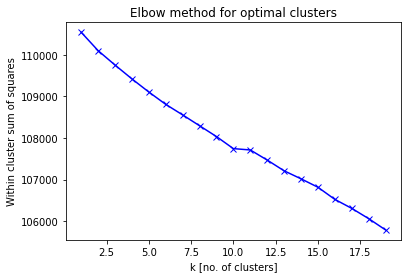

In [57]:
wcss = [] # Within Cluster Sum of Squares - sum of sq distances
K = range(2, 12)

for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', 
                    max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X3)
    wcss.append(kmeans.inertia_)

plt.plot(K, wcss, 'o')
plt.title('Elbow method for optimal clusters')
plt.xlabel('k [no. of clusters]')
plt.ylabel('Within cluster sum of squares')
plt.show()

We see a distict bend (elbow) at k=10

In [59]:
print(words[250:300])

['dhcp', 'die', 'differ', 'difficult', 'direct', 'disabl', 'disagre', 'discuss', 'disk', 'display', 'distribut', 'dlss', 'dns', 'doc', 'docker', 'document', 'dollar', 'domain', 'doubl', 'doubt', 'download', 'draw', 'drive', 'driver', 'drop', 'dumb', 'dynam', 'e', 'earli', 'easi', 'easier', 'easili', 'edg', 'edit', 'educ', 'effect', 'effici', 'effort', 'email', 'employ', 'employe', 'enabl', 'encrypt', 'end', 'engin', 'enjoy', 'ensur', 'enterpris', 'entir', 'entri']


In [60]:
true_k = 10
model = KMeans(n_clusters=true_k, 
               init='k-means++',
               max_iter=300,
               random_state=0)

model.fit(X3)


KMeans(n_clusters=10, random_state=0)

In [61]:
common_words = model.cluster_centers_.argsort()[:, -1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : googl, paper, search, timnit, email, compani, ai, review, ethic, servic, twitter, work, point, issu, cloud, product, employe, answer, map, intern, read, research, process, support, facebook
1 : compani, job, manag, pay, experi, hire, team, tech, person, engin, product, start, learn, money, employe, posit, day, role, work, level, interview, busi, big, great, problem
2 : card, nvidia, price, amd, buy, perform, review, gpu, launch, product, xt, gpus, sell, market, msrp, stock, rtx, seri, dlss, ti, suppli, point, hardwar, driver, graphic
3 : secur, password, cyber, manag, user, account, attack, network, access, chang, job, email, cert, start, compani, experi, devic, requir, polici, set, hack, softwar, learn, certif, issu
4 : server, network, window, connect, devic, linux, instal, access, client, set, user, manag, dns, updat, host, run, file, switch, firewal, issu, vlan, configur, traffic, machin, support
5 : x, appl, core, power, intel, m, chip, perform, nm, cpu, arm, amd, w, zen, b, c

### Kmeans on ngrams (comment + post title)

In [41]:
# remove NaNs
cmnt_title_ngrams.dropna(axis=0, inplace=True)

In [42]:
len(cmnt_title_ngrams.ngram)

5428597

Extracting features from the training dataset

In [47]:
ngram_vectorizer = TfidfVectorizer(stop_words = stop_words,
                                   tokenizer = tokenize,
                                   max_features = 3000)

X_ngram = ngram_vectorizer.fit_transform(cmnt_title_ngrams.ngram)

words = ngram_vectorizer.get_feature_names()
print(len(words))
print(words[:50]) 

3000
['aa', 'aaa', 'abandon', 'abil', 'absolut', 'abstract', 'absurd', 'abus', 'academ', 'academia', 'acceler', 'accept', 'access', 'accid', 'accident', 'accomplish', 'account', 'accur', 'accuraci', 'accus', 'achiev', 'acknowledg', 'acl', 'acquir', 'acquisit', 'action', 'activ', 'actor', 'adapt', 'add', 'addit', 'address', 'adequ', 'adjust', 'admin', 'administr', 'admit', 'adob', 'adopt', 'adult', 'advanc', 'advantag', 'adversari', 'advertis', 'advic', 'advis', 'advisor', 'advoc', 'afaik', 'afford']


In [48]:
print("n_samples: %d, n_features: %d" % X_ngram.shape)

n_samples: 5428597, n_features: 3000


Performing dimensionality reduction using LSA

In [69]:
# t0 = time()
# svd = TruncatedSVD(100)
# normalizer = Normalizer(copy=False)
# lsa = make_pipeline(svd, normalizer)

# X = lsa.fit_transform(X_ngram)

# print("done in %fs" % (time() - t0))

# explained_variance = svd.explained_variance_ratio_.sum()
# print("Explained variance of the SVD step: {}%".format(
#         int(explained_variance * 100)))

done in 394.063323s
Explained variance of the SVD step: 14%


In [31]:
# wcss = [] # Within Cluster Sum of Squares - sum of sq distances
# K = range(2, 12)

# for k in K:
#     kmeans = KMeans(n_clusters=k, init='k-means++', 
#                     max_iter=300, n_init=10)
#     kmeans.fit(X_ngram)
#     wcss.append(kmeans.inertia_)

# plt.plot(K, wcss)
# plt.title('Elbow method for optimal clusters')
# plt.xlabel('k [no. of clusters]')
# plt.ylabel('Within cluster sum of squares')
# plt.show()

In [53]:
true_k = 10
model = MiniBatchKMeans(n_clusters=true_k, 
                        init='k-means++', 
                        batch_size=500,
                        n_init=10)

t0 = time()
model.fit(X_ngram)
print("done in %0.3fs" % (time() - t0))

done in 5.001s


In [54]:
terms = ngram_vectorizer.get_feature_names()
len(terms)

3000

In [55]:
for k in range(true_k):
    print("Cluster %d:" % k, end='')
    for i in model.cluster_centers_.argsort()[:, ::-1][k, :30]:
        print(' %s' % terms[i], end='')
    print('\n\n')

Cluster 0: period approach basic split laptop flagship fell flash flat flaw fewer fetch femal felt fellow feet fibr feel feedback feed fee feder fed featur feasibl fiber field flag fine fit


Cluster 1: mind memori busi team manufactur kotlin workplac state comput design test issu hell member speed pick client instal offer great long person file firm felt fellow firewal fell feet firmwar


Cluster 2: mit grant assum standard case databas persist issu felt fight field fibr fiber fewer fetch femal feet fellow fell feel feedback feed fee feder fed featur figur zoom file firefox


Cluster 3: compani code manag server data issu network perform user problem game learn support product set job day secur person test develop softwar read comput understand requir review core base googl


Cluster 4: elev intern safeti news guarante net singl general fight field fibr fiber fewer fetch femal felt expos fellow figur feet feel feedback feed fee feder fed featur fell file fear


Cluster 5: extra die sk

In [57]:
print(len(terms))
print(terms[200:300])

3000
['bad', 'bag', 'bake', 'balanc', 'ball', 'ban', 'band', 'bandwidth', 'bang', 'bank', 'banner', 'bar', 'bare', 'barrier', 'base', 'baselin', 'bash', 'basi', 'basic', 'batch', 'batteri', 'battl', 'bay', 'bb', 'bear', 'beast', 'beat', 'beauti', 'bed', 'beginn', 'behav', 'behavior', 'behaviour', 'belief', 'bell', 'belong', 'bench', 'benchmark', 'benefici', 'benefit', 'bert', 'bet', 'beta', 'bgp', 'bias', 'bid', 'big', 'bigger', 'biggest', 'billion', 'bin', 'binari', 'bind', 'bio', 'biolog', 'bit', 'bitch', 'bite', 'bitlock', 'black', 'blacklist', 'blah', 'blame', 'blank', 'bleed', 'blind', 'bloat', 'blob', 'block', 'blog', 'blow', 'blue', 'bluetooth', 'board', 'boat', 'bob', 'bodi', 'boil', 'bond', 'bonus', 'book', 'boost', 'boot', 'bootcamp', 'bore', 'born', 'boss', 'bot', 'bother', 'bottleneck', 'bought', 'bounc', 'bound', 'boundari', 'box', 'boy', 'brain', 'branch', 'brand', 'breach']


#### Save model

In [60]:
pickle.dump(model, open(f'{MODEL_DIR}/kmean_ngram.pkl', 'wb'))

## Kmeans on clean comments and titles that have it-trends-terms in them

In [58]:
comments_w_terms.head()

,counts,comment,reduced_500,reduced_200,reduced_150,reduced_100,reduced_50,comment_terms
0,1,undergraduate cybersec train included required...,write,No Match Found,No Match Found,No Match Found,No Match Found,{'list'}
1,1,meaningful add assuming snmp write access enab...,solve problems,access,access,No Match Found,No Match Found,{'access'}
2,1,l2tp ipsec primally vpn gateway unifi security...,network security,security,security,security,security,{'vpn'}
3,1,interesting virtualbox handles case,case,case,case,case,No Match Found,{'virtualbox'}
4,1,companies building adopting internal developer...,tech companies,tech companies,working,working,No Match Found,{'puppet'}


In [61]:
len(comments_w_terms.comment)

43781

In [59]:
titles_w_terms.head()

,counts,title,reduced_500,reduced_200,reduced_150,reduced_100,reduced_50,title_terms
0,552,thread product manager google google cloud pla...,google,google,google,google,No Match Found,{'aws'}
1,504,ruby released,No Match Found,No Match Found,No Match Found,No Match Found,No Match Found,{'ruby'}
2,481,git 15 created svn created 5 git cvs 15 svn,5,5,5,5,No Match Found,{'git'}
3,400,nissan source code leaked online git repo misc...,source code,source code,source code,source code,source code,{'git'}
4,381,cookie github blog,github,No Match Found,No Match Found,No Match Found,No Match Found,{'github'}


In [63]:
len(titles_w_terms.title)

2814

In [64]:
cmnt_title_w_terms = list(comments_w_terms.comment) + list(titles_w_terms.title)

In [65]:
len(cmnt_title_w_terms)

46595

In [66]:
data_w_terms_vectorizer = TfidfVectorizer(stop_words = stop_words,
                                          tokenizer = tokenize,
                                          max_features = 3000)

X_terms = data_w_terms_vectorizer.fit_transform(cmnt_title_w_terms)

term = data_w_terms_vectorizer.get_feature_names()
print(len(terms))
print(terms[:50]) 

3000
['aa', 'aaa', 'abandon', 'abil', 'absolut', 'abstract', 'absurd', 'abus', 'academ', 'academia', 'acceler', 'accept', 'access', 'accid', 'accident', 'accomplish', 'account', 'accur', 'accuraci', 'accus', 'achiev', 'acknowledg', 'acl', 'acquir', 'acquisit', 'action', 'activ', 'actor', 'adapt', 'add', 'addit', 'address', 'adequ', 'adjust', 'admin', 'administr', 'admit', 'adob', 'adopt', 'adult', 'advanc', 'advantag', 'adversari', 'advertis', 'advic', 'advis', 'advisor', 'advoc', 'afaik', 'afford']


In [67]:
true_k = 10
model = MiniBatchKMeans(n_clusters=true_k, 
                        init='k-means++', 
                        batch_size=500,
                        n_init=10)

t0 = time()
model.fit(X_terms)
print("done in %0.3fs" % (time() - t0))

done in 0.330s


In [68]:
for k in range(true_k):
    print("Cluster %d:" % k, end='')
    for i in model.cluster_centers_.argsort()[:, ::-1][k, :30]:
        print(' %s' % terms[i], end='')
    print('\n\n')

Cluster 0: sequenti distinct design dkim hide cissp civil width address neat maintain serial rebas server conclud split iot comptia access automat fear linux background fellow infinit provis warranti legitim chapter suffer


Cluster 1: gear lightweight gdpr histor chipset distract iot cleaner tire runtim prohibit organis automat ipv suffer layout fear angular irc cat rate stack object chapter gebru hybrid gpo lie purpos pro


Cluster 2: access fraction colleg analysi antivirus apach smtp deriv produc curv suffer maintain guidanc phish ghost frequenc pro perfect server serial bullshit convinc cleaner complain depth tensorflow constant postgr iot capabl


Cluster 3: neat secondari fellow asus access deriv colleg layout ise maintain stack rotat mailbox cross snapshot conclud town chipset civil smtp emot curv categori udp target caught bash iot complain lecun


Cluster 4: width lift sequenti univers infinit lowest low doubl deni metal suffer fear iot smtp arguabl maintain vault lag upgrad 

### Save model

In [69]:
pickle.dump(model, open(f'{MODEL_DIR}/kmean_terms.pkl', 'wb'))